Bybitの約定データの分布を確認する。


　
## やりたいこと

### 約定データを分析する。

#### 統計量の表示

#### 分布のグラフ化
まずは約定価格の頻度をプロットする。
seabonのdistplot関数を使う。
https://seaborn.pydata.org/generated/seaborn.distplot.html
sns.distplot(data, fit=norm, bins=50)

#### 対数収益率

#### ドルバー



In [4]:
import datetime
import time

import scipy.stats as stats
from scipy.stats import norm, t
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.random import randn
import os
from urllib import request
import pandas as pd
import datetime

In [43]:
def get_bb_log(yyyy, mm, dd, symbol="BTCUSD"):
    '''
    bybitからパラメーターに指定された日付の約定データを/tmpにダウンロードする。
    /tmpに一時保存することでキャッシュ機能を実現
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :param symbol: オプション：ディフォルトBTCUSD
    :return: /tmpにダウンロードしたファイル名
    '''
    file_name = f'{symbol}{yyyy:04d}-{mm:02d}-{dd:02d}.csv.gz'
    tmp_file = '/tmp/'+ file_name

    if not os.path.exists(tmp_file):
        download_url = f'https://public.bybit.com/trading/{symbol}/{file_name}'
        print("download url=", download_url)
        request.urlretrieve(download_url, tmp_file)

    return tmp_file

def get_bb_df(yyyy, mm, dd):
    '''
    bybitから約定データをダウンロードしpandasのDataFrameオブジェクトにする。
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :return: 約定データが入ったDataFrame
    '''
    file = get_bb_log(yyyy, mm, dd)

    bb_df = pd.read_csv(file, index_col=0)
    bb_df.index = pd.to_datetime(bb_df.index, utc=True, unit='s')

    return bb_df


def resample_ohlcv(data, sample_time):
    '''
    約定データからohlcvを作成する。
    timeに指定できるパラメータは文字列で以下のように指定する。
    15秒:'15S' / 1分: '1T' / 1時間: '1H'
    詳細はpadnasのドキュメント
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    :param data:　bybitの約定データの入ったDataFrame
    :param sample_time: サンプル間隔
    :return: ohlcvデータ
    '''
    resample_df = data['price'].resample(sample_time).ohlc()
    resample_df['volume'] = data['size'].resample(sample_time).sum()
    return resample_df

def get_bb_df_past_days(days=10, start_day = None):
    if not start_day:
        start_day = datetime.date.today() - datetime.timedelta(days=days+2)
    print(start_day, "->", start_day + datetime.timedelta(days=days))

    df = None
    for i in range(days):
        target_day = start_day + datetime.timedelta(days=i)
        download_df = get_bb_df(target_day.year, target_day.month, target_day.day)
        if df is None:
            df = download_df
        else:
            df = df.append(download_df)

    return df


def show_dist(data):
    sns.distplot(data, fit=norm, bins=50)
    plt.show()

def probplot(data):
    stats.probplot(data, plot=plt)
    plt.show()

def show_stats(data):
    w = stats.shapiro(data)
    print("sharp ratio=", w)

    k = stats.kstest(data, 'norm')
    print("KS ratio=", k)


def compare_normal_dist(data):
    show_dist(data)
    probplot(data)
    show_stats(data)

正規分布での確認

In [44]:
df = get_bb_df_past_days(3)

2021-09-21 -> 2021-09-24


In [45]:
print(df.head())
print(df.tail())

                                     symbol side  size    price  \
timestamp                                                         
2021-09-21 23:59:59.980000+00:00     BTCUSD  Buy  1654  40711.0   
2021-09-21 23:59:59.938999808+00:00  BTCUSD  Buy   796  40711.0   
2021-09-21 23:59:59.938999808+00:00  BTCUSD  Buy     1  40711.0   
2021-09-21 23:59:59.938999808+00:00  BTCUSD  Buy     3  40711.0   
2021-09-21 23:59:59.938999808+00:00  BTCUSD  Buy   427  40710.5   

                                     tickDirection  \
timestamp                                            
2021-09-21 23:59:59.980000+00:00     ZeroMinusTick   
2021-09-21 23:59:59.938999808+00:00  ZeroMinusTick   
2021-09-21 23:59:59.938999808+00:00  ZeroMinusTick   
2021-09-21 23:59:59.938999808+00:00       PlusTick   
2021-09-21 23:59:59.938999808+00:00  ZeroMinusTick   

                                                               trdMatchID  \
timestamp                                                                 

/Users/takeoyasukawa/Projects/bbanalyze/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


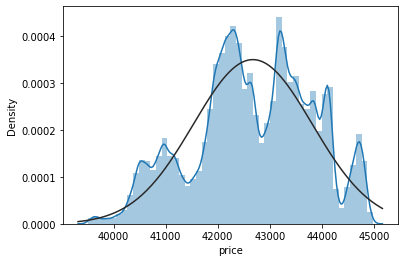

In [46]:

show_dist(df['price'])

/Users/takeoyasukawa/Projects/bbanalyze/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


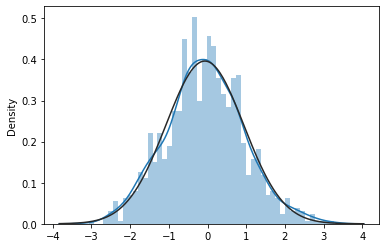

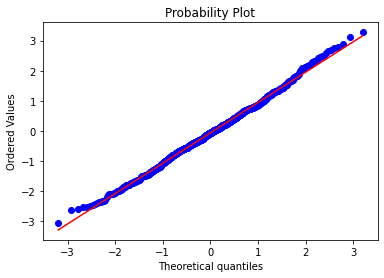

sharp ratio= ShapiroResult(statistic=0.9974300861358643, pvalue=0.11586377769708633)
KS ratio= KstestResult(statistic=0.041384962633233435, pvalue=0.06326273708336805)


In [7]:
compare_normal_dist(r)